In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#needed to import qke procedures
import sys
from pathlib import Path

main_dir = str(Path().resolve().parent)
sys.path.insert(1, main_dir)

In [3]:
#scikit learn and tools
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
from qiskit_algorithms.utils import algorithm_globals

#set the seed(s)
np.random.seed(123)
algorithm_globals.random_seed = 123

#load dataset with panda
#data are scaled outside the notebook
env = pd.read_csv('../data/env.sel3.scaled.csv') 
#take a look of the dataset

print(f'DESCRIBE DATASET')
display(env.describe())


#DEFINE design matrix
#slice dataset
f_rate = 0.05
env_slice = env.sample(frac=f_rate, random_state=123)

Y = env_slice['occupancy']
#X = env[['illuminance', 'blinds','lamps','co', 'rh', 'co2', 'temp']]
X = env_slice[['illuminance', 'blinds','lamps','rh', 'co2', 'temp']]

print(f'HEAD')
display(X.head())

DESCRIBE DATASET


,illuminance,blinds,lamps,rh,co2,temp,occupancy
count,2.865000e+03,2865.000000,2865.000000,2865.000000,2.865000e+03,2.865000e+03,2865.000000
mean,-3.571314e-16,0.801622,0.596464,0.473229,-5.952190e-16,-7.142629e-16,-0.130192
std,1.000000e+00,0.372305,0.489316,0.080185,1.000000e+00,1.000000e+00,0.991662
min,-1.016287e+00,0.000000,0.000000,0.243300,-1.222685e+00,-1.774534e+00,-1.000000
25%,-8.575745e-01,1.000000,0.000000,0.433700,-8.492006e-01,-8.538436e-01,-1.000000
50%,-6.989177e-02,1.000000,1.000000,0.491100,-3.252814e-01,-1.940149e-01,-1.000000
75%,3.357060e-01,1.000000,1.000000,0.524100,7.569402e-01,7.266751e-01,1.000000
max,8.559349e+00,1.000000,1.000000,0.633300,3.583699e+00,2.614091e+00,1.000000


HEAD


,illuminance,blinds,lamps,rh,co2,temp
1618,-0.064014,1.0,1.0,0.5112,0.513679,-0.894763
610,1.552499,1.0,1.0,0.3178,-0.802352,0.992653
1667,-0.969261,1.0,0.0,0.5350,0.115264,-0.853844
2481,-0.134552,0.0,1.0,0.5418,0.601788,-1.421603
2638,-0.434342,1.0,0.0,0.5088,0.469415,-0.587866


In [4]:
#split design matrix (25% of the design matrix used for test)
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=123)
NUM_QUBIT =  X_train.shape[1]
#sanity check
print(f'TRAIN***** {X_train.shape}')
print(f'TEST***** {X_test.shape}')
print(f'Number of Qbit:  {NUM_QUBIT}')

TRAIN***** (107, 6)
TEST***** (36, 6)
Number of Qbit:  6


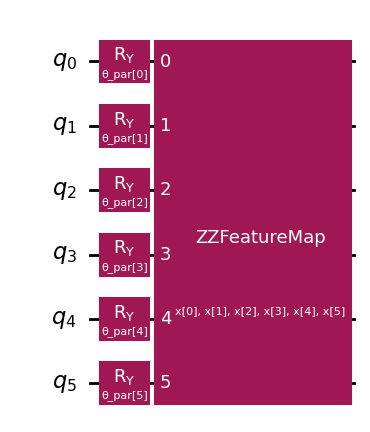

In [6]:
#get the feature mao
from pqk.TrainableCircuits import TrainableCircuits

qc_trainable = TrainableCircuits.zzfm(n_wire=NUM_QUBIT)

fm = qc_trainable.qc
training_params = qc_trainable.training_parameters


fm.draw('mpl')

In [7]:
#define the trainable kernel
from qiskit_machine_learning.kernels import TrainableFidelityStatevectorKernel

q_kernel = TrainableFidelityStatevectorKernel(feature_map=fm, training_parameters=training_params)

In [8]:
#get the optimized kernel
from qiskit_machine_learning.kernels.algorithms.quantum_kernel_trainer import QuantumKernelTrainer
from qiskit_algorithms.optimizers import SPSA
from qiskit_machine_learning.utils.loss_functions import SVCLoss

#define the callback
from pqk.QKCallback import QKCallback
my_callback = QKCallback()


spsa_opt = SPSA(maxiter=20, learning_rate=0.03, perturbation=0.01, termination_checker=my_callback.callback)
loss_func = SVCLoss(C=1.0)

#one initial point per trainable parameter
#init_point=[np.pi/2]
init_point = np.random.uniform(size=NUM_QUBIT)

qk_trainer = QuantumKernelTrainer(quantum_kernel=q_kernel, loss=loss_func, initial_point= init_point, optimizer=spsa_opt)
qkt_results = qk_trainer.fit(X_train, y_train)

optimized_kernel = qkt_results.quantum_kernel

**********************
Print callback. Iteration 1
Number of function evaluations: 2
The paramenters: [0.75388159 0.22872693 0.16943905 0.49390236 0.66205657 0.48051886]
The function value: 46.517919767487356
The stepsize: 0.1406310950623905
Whether the step was accepted: True
**********************
**********************
Print callback. Iteration 2
Number of function evaluations: 4
The paramenters: [0.68890449 0.29370403 0.10446195 0.42892526 0.59707946 0.54549597]
The function value: 46.40762280154705
The stepsize: 0.1591607497788903
Whether the step was accepted: True
**********************
**********************
Print callback. Iteration 3
Number of function evaluations: 6
The paramenters: [0.6262155  0.35639302 0.04177296 0.36623628 0.53439048 0.60818495]
The function value: 46.268867781539484
The stepsize: 0.1535560179276413
Whether the step was accepted: True
**********************
**********************
Print callback. Iteration 4
Number of function evaluations: 8
The paramente

In [9]:
from qiskit_machine_learning.algorithms.classifiers import QSVC
qsvc = QSVC(quantum_kernel=optimized_kernel)

In [10]:
#trainingprediction...
qsvc.fit(X_train, y_train)

QSVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
     decision_function_shape='ovr', degree=3, gamma='scale', max_iter=-1,
     probability=False,
     quantum_kernel=<qiskit_machine_learning.kernels.trainable_fidelity_statevector_kernel.TrainableFidelityStatevectorKernel object at 0x741aa6513020>,
     random_state=123, shrinking=True, tol=0.001, verbose=False)

In [11]:
from sklearn.metrics import accuracy_score

#result...
predictions = qsvc.predict(X_test)
score = accuracy_score(predictions, y_test)

print(f'*******SCORE: {score}')


*******SCORE: 0.5277777777777778


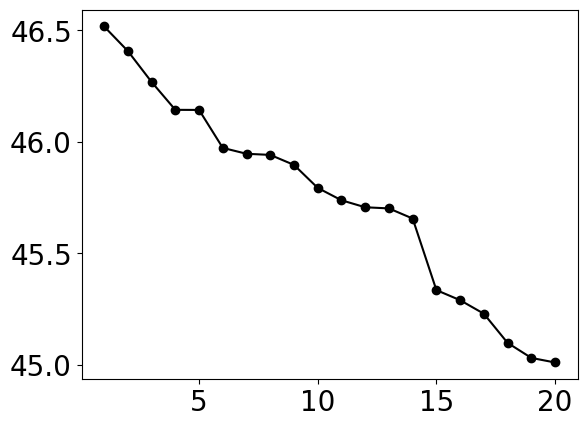

In [12]:
#plot data
my_callback.plot_data()

In [13]:
#tray save callback data
my_callback.save(prefix='callback_')